# 1.2 - Multilinear Regression

Purpose: Given a dataset $((x_{11}, x_{12}, \cdots, x_{1n}, y_1), (x_{21}, x_{22}, \cdots, x_{2n}, y_2), \cdots, (x_{N1}, x_{N2}, \cdots, x_{Nn}, y_N))$ with __multiple__ (n) features and a response variable, with $P$ measurements, to find the "best" linear function $f(x) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n$ that fits the data. Usually, "best" means to minimize the mean squared error between the linear fit and the data points.

Any combination $(\beta_0, \beta_1, \beta_2, \cdots, \beta_n)$ leads to a well-defined function which generates "predictions" $\hat{y}_i = f(x_i)$ for any given $\{x_i^j\}$. A residual is the distance between this prediction and the "true" value (in the dataset) $y_i$ and the predicted value $\hat{y}_i$: $r = y_i - \hat{h}_i$. 

Computing the residuals across the whole dataset, computing their squared values, and then averaging them all generates the MSE: $\mathrm{MSE} = \frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y}_i)^2$. This acts as the loss function that is being minimized to find the best choice of parameters.

This minimization can be done analytically to generate closed form solutions for the parameters!

This problem can be re-expressed in vector-matrix notation. Let $X_p = (x_{1p}, x_{2p}, \cdots, x_{np})$ contain all the $n$ features for a given prediction index $p$, with corresponding response $y_p$. First, define a unity vector $\mathcal{I} = (1, ..., 1)$. We collect all the measurements together into a $(n \times (P+1))$ matrix $X = (\mathcal{I}, X_1, \cdots, X_P)$, with the responses in vector $Y = (y_1, \cdots, y_P)^T$, and the coefficients in $\beta = (\beta_0, \beta_1, ..., \beta_P)^T$. Then, we can write the model predictions as $$\hat{f}(X) = \hat{Y} = X \hat{\beta}.$$

To be clear: $X$ is an $(n \times (P+1))$ matrix, $\beta$ is a $(P+1 \times 1)$ column vector, and the product, $\hat{Y}$ is a $(n \times 1)$ column vector.
With this, the MSE becomes $\mathrm{MSE} = \frac{1}{n} ||\hat{Y} - X \hat{\beta}||^2$. The coefficients that minimize the MSE are 
$$\hat{\beta} = (X^T X)^{-1} X^T \hat{Y}.$$

Code: I implement a function that uses the analytical expression for the coefficients, and compare it with the output from scikitlearn. I use this in a very simple example that follows a multilinear form with some noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from data_generation import generate_linear_noisy_data

def pad_matrix_with_ones(M):
    """receive a (n, P) matrix M, pad it on the left with ones to return a (n, P+1) matrix to be used in MLR"""
    # Get the number of rows in the matrix
    n = M.shape[0]
    
    # Create a column vector of ones with the same number of rows as the input matrix
    ones_column = np.ones((n, 1))
    
    # Concatenate the column vector of ones with the input matrix horizontally
    padded_M = np.hstack((ones_column, M))
    
    return padded_M


def estimate_coefficients_multilinear(X, Y):
    """ 
    X: feature matrix, padded with ones on the left
    Y: response vector
    """
    XT = np.transpose(X)
    coeffs = np.linalg.inv(XT @ X) @ XT @ Y
    return coeffs

def linear_regression_estimate(X, beta):
    return X @ beta

def multilinear_regression_coeffs_scikit(X, y):
    """
    Perform linear regression analysis on the given dataset.
    
    Parameters:
    X (array-like): Independent variable.
    y (array-like): Dependent variable.
    
    Returns:
    slope (float): Slope of the fitted line.
    intercept (float): Intercept of the fitted line.
    """
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Get the slope and intercept of the fitted line
    coeffs = [model.intercept_] + list(model.coef_)

    y_pred = model.predict(X)

    
    return y_pred, coeffs


In [2]:
def generate_linear_noisy_data(num_points, x_amp, noise_strength, coefficients):
    """ given a vector of n amplitudes, generate a multilinear response y = intercept + coefficients """
    # Set random seed for reproducibility
    np.random.seed(1)
    
    # Generate random x values between 0 and 10
    num_feats = len(x_amp)
    X = np.zeros((num_points, num_feats))
    for i in range(0, num_feats):
        X[:, i] = x_amp[i] * np.random.rand(num_points)

    X_padded = pad_matrix_with_ones(X)
    
    # Generate y values using a linear relationship with noise
    y_true = X_padded @ coefficients

    # Generate random noise for y values
    noise = noise_strength * np.random.randn(num_points)
    
    y_noise = y_true + noise
    return X, X_padded, y_true, y_noise

# Generate example
num_points = 50
noise_strength = 1
#x_amp = (10, 5, 1)
#coefficients = (2, 3, 5, 10) #intercept and slopes
x_amp = (10, 5)
coefficients = (2, 3, 5) #intercept and slopes


X, X_padded, Y_true, Y = generate_linear_noisy_data(num_points, x_amp, noise_strength, coefficients)


In [3]:
est_coeffs = estimate_coefficients_multilinear(X_padded, Y)
y_pred = linear_regression_estimate(X_padded, est_coeffs)
y_pred_scikit, est_coeffs_scikit = multilinear_regression_coeffs_scikit(X, Y)
print(f'Linear coefficients estimated to be: \n {est_coeffs} \n Estimated by scikit: \n {est_coeffs_scikit} \nActual values: \n {coefficients}')
print(f'Predicted responses are the same: {np.allclose(y_pred, y_pred_scikit, atol=0.01)}')

Linear coefficients estimated to be: 
 [2.51568297 2.961651   4.88716632] 
 Estimated by scikit: 
 [2.515682971504905, 2.9616509983189925, 4.887166315295157] 
Actual values: 
 (2, 3, 5)
Predicted responses are the same: True


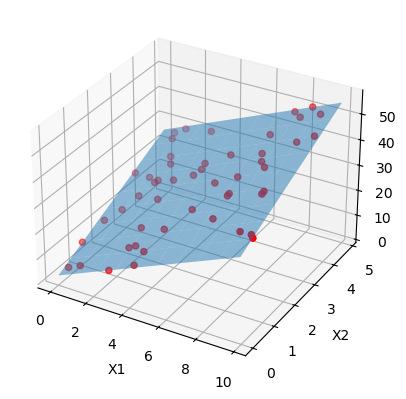

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_multilinear(X, Y, coeffs):
    # Plot the data and the plane
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the data points
    X1 = X[:, 1]
    X2 = X[:, 2]
    ax.scatter(X1, X2, Y, c='r', marker='o')
    
    # Create a meshgrid for the plane
    x1_plane = np.linspace(min(X1), max(X1), 10)
    x2_plane = np.linspace(min(X2), max(X2), 10)
    X1_plane, X2_plane = np.meshgrid(x1_plane, x2_plane)
    Y_plane = coeffs[0] + coeffs[1]*X1_plane + coeffs[2]*X2_plane
    
    # Plot the plane
    ax.plot_surface(X1_plane, X2_plane, Y_plane, alpha=0.5)
    
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('y')
    return fig 

fig = plot_multilinear(X_padded, y_pred, est_coeffs)
plt.show()
